# Functions for Iterative Voice Coil Waveform Correction

In [187]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from statsmodels.tsa.holtwinters import SimpleExpSmoothing



def load_and_preprocess_data(filepath, start_time=0, end_time=0.023):
    """
    Load a tab-separated CSV file and preprocess the data.

    Steps:
    1. Load data from the given file path, ensuring 'second' and 'Volt' columns are numeric.
    2. Normalize 'Volt' values to the range [0, 1], using the first value as the baseline minimum
       and the maximum value in the column as the upper bound.
    3. Extract only the portion of the data between start_time and end_time (in seconds).
    
    Args:
        filepath (str): Path to the input CSV file.
        start_time (float, optional): Start time in seconds for data isolation. Default is 0.
        end_time (float, optional): End time in seconds for data isolation. Default is 0.023.
    
    Returns:
        pandas.DataFrame: Preprocessed subset of the data with normalized 'Volt' values.
    """

    # Load the CSV data
    data = pd.read_csv(filepath, sep='\t')
    data['second'] = pd.to_numeric(data['second'], errors='coerce')
    data['Volt'] = pd.to_numeric(data['Volt'], errors='coerce')
    
    # Normalize the 'Volt' data to the range [0, 1]
    # data_min = data['Volt'].min()
    data_min = data['Volt'].iloc[0]
    data_max = data['Volt'].max()
    data['Volt'] = (data['Volt'] - data_min) / (data_max - data_min)
    
    # Isolate the desired period
    period_data = data[(data['second'] >= start_time) & (data['second'] <= end_time)]
    return period_data

def normalize_to_range(data):
     """
    Normalize an array-like dataset to the range [0, 1].

    The function shifts and scales the input values so that:
      - The minimum value maps to 0
      - The maximum value maps to 1
      - All other values are proportionally scaled in between

    Args:
        data (array-like): Input numeric data (NumPy array, list, or similar).

    Returns:
        numpy.ndarray: Normalized data in the range [0, 1].
    """
    min_val = np.min(data)
    max_val = np.max(data)
    
    normalized_data = (data - min_val) / (max_val - min_val)
    
    return normalized_data

def smooth_data(period_data):
    """
    Smooth the 'Volt' signal in the given DataFrame.

    By default, this function simply returns the raw 'Volt' values.  
    The code includes (commented out) an option to apply a Savitzky-Golay filter 
    for smoothing and then normalizing the signal, which can be enabled if needed.

    Args:
        period_data (pandas.DataFrame): DataFrame containing a 'Volt' column.

    Returns:
        pandas.Series: Smoothed (or raw) 'Volt' data.
    """

    # polynomial_order = 3
    # smoothed_data = normalize_to_range(savgol_filter(period_data['Volt'].values, window_length, polynomial_order))
    smoothed_data = period_data['Volt']
    return smoothed_data


def find_extrema(data):
    """
    Identify local maxima and minima in a 1D dataset.

    A point is considered a:
      - Local maximum if it is greater than its immediate neighbors.
      - Local minimum if it is smaller than its immediate neighbors.

    Args:
        data (array-like): 1D sequence of numeric values (e.g., list, NumPy array, pandas Series).

    Returns:
        tuple: Two lists containing the indices of local maxima and local minima, respectively.
    """
    maxima = []
    minima = []

    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1]:  # Local Maximum
            maxima.append(i)
        elif data[i] < data[i - 1] and data[i] < data[i + 1]:  # Local Minimum
            minima.append(i)

    return maxima, minima


def generate_curved_line(start_value, end_value, length, curvature=0):
    """
    Generate a 1D line with an optional quadratic curvature.

    This function first creates a straight line between start_value and end_value, 
    then adds a quadratic curve centered at the midpoint to simulate optical 
    residuals along laser beam propagation.

    Args:
        start_value (float): Starting value of the line.
        end_value (float): Ending value of the line.
        length (int): Number of points in the generated line.
        curvature (float, optional): Curvature strength. 
            - 0 → pure linear line
            - >0 → upward curve
            - <0 → downward curve
            Default is 0.

    Returns:
        numpy.ndarray: Array representing the curved line.
    """
    
    
    # 1. Generate the linear line
    linear_line = np.linspace(start_value, end_value, length)

    # 2. Create a quadratic curve centered around the midpoint
    x = np.linspace(-length/2, length/2, length)  # Centered x-values
    quadratic_curve = curvature * x**2

    # 3. Add the curve to the linear line becasue of optical residual along laser beam propagation
    curved_line = linear_line + quadratic_curve

    return curved_line

def compute_progressive_compensator(smoothed_data, time_data_input, residual=None, previous_ideal_plus_compensator=None):
     """
    Compute and update a progressive compensator for correcting residual distortions.

    The function compares the smoothed signal with an ideal linear reference, 
    applies residual corrections, and progressively updates the compensator 
    across iterations.

    Behavior:
      - On the first call (when `previous_ideal_plus_compensator` is None), 
        it initializes the compensator as `ideal_linear + residual` and 
        plots the smoothed data, compensator, and ideal reference.
      - On subsequent calls, it updates the compensator by adding the residual 
        to the previous compensator and normalizing to [0, 1].

    Args:
        smoothed_data (array-like): Preprocessed (smoothed) signal data.
        time_data_input (array-like): Corresponding time axis values.
        residual (array-like, optional): Residual error to be corrected. Default is None.
        previous_ideal_plus_compensator (array-like, optional): Compensator from 
            the previous iteration. Default is None.

    Returns:
        tuple:
            ideal_linear (array-like): Reference ideal linear signal.
            compensator (array-like): Updated compensator.
            previous_ideal_plus_compensator (array-like): Stored compensator 
                for use in the next iteration.
    """
        
    global start_value, end_value, ideal_linear, start_time, end_time, time_data

    time_data = time_data_input
    
    curvature = 0
    if previous_ideal_plus_compensator is None:

        compensator = ideal_linear + residual
        ideal_plus_compensator = ideal_linear + residual
        
        plt.figure(figsize=(7.5, 5))
        plt.plot(smoothed_data,label='smoothed_data')
        plt.plot(compensator, label='ideal_plus_compensator')
        plt.plot(ideal_linear,label='ideal_linear')
        
        plt.title('')
        plt.xlabel('Time (s)')
        plt.ylabel('Normalized Voltage')
        plt.legend()
        plt.grid(True)
        
    else:
        compensator = normalize_to_range(residual+previous_ideal_plus_compensator)

    
    
    previous_ideal_plus_compensator = compensator

    return ideal_linear, compensator, previous_ideal_plus_compensator


def visualize_transformation_with_history(period_data, smoothed_data, ideal_linear, compensator):
    """
    Rescale the compensator signal to a fixed range for visualization.

    The function takes the "Ideal Linear + Compensator" signal and linearly
    rescales it from its current min/max range into the interval [1.23, 1.33].
    These values are chosen for the current system, but the target range 
    (desired_min, desired_max) may vary for other systems depending on 
    calibration or application needs.

    Args:
        period_data (pandas.DataFrame): Original time-windowed data (not directly used here).
        smoothed_data (array-like): Smoothed signal (not directly used here).
        ideal_linear (array-like): Ideal reference linear signal (not directly used here).
        compensator (array-like): Signal to be rescaled.

    Returns:
        numpy.ndarray: Compensator rescaled to the range [1.23, 1.33] (system-dependent).
    """
    
    # Allow user to specify desired min and max for scaling
    desired_min = 1.23
    desired_max = 1.33
    
    # Scale the "Ideal Linear + Compensator" data to the desired min and max
    current_min = compensator.min()
    current_max = compensator.max()
    compensator_scaled = ((compensator - current_min) / (current_max - current_min)) * (desired_max - desired_min) + desired_min
    
    
    return compensator_scaled

def extended_data(period_data, ideal_plus_compensator_scaled):
    """
    Extend the compensated signal at its far edge to enforce waveform symmetry.

    The function appends an additional segment to the compensated signal by 
    extending from its maximum value down to its minimum value. The extension 
    length is set to 10% of the original signal length, resulting in an 
    approximately 90% symmetry in the waveform.

    Args:
        period_data (pandas.DataFrame): Original isolated data (not directly used here).
        ideal_plus_compensator_scaled (array-like): Scaled compensator signal.

    Returns:
        numpy.ndarray: Combined signal with the extended segment appended.

    Notes:
        - The 10% extension ratio is system-specific and can be adjusted 
          depending on the desired symmetry or application.
        - The extension is generated using a linear interpolation from max 
          to min value of the signal.
    """
    # Data prepration by extending the far edge of the data to the minimum value
    # The extended far end is 10% of whole data resulting in the 90% symmertry in the waveform
    
    # Identify the maximum and minimum values from the column
    max_value = ideal_plus_compensator_scaled.max()
    min_value = ideal_plus_compensator_scaled.min()

    # Calculate the number of samples for the extension
    sample_count = int(len(ideal_plus_compensator_scaled) * 0.1)

    # Generate the extension data
    extension = np.linspace(max_value, min_value, sample_count)

    # Append the extension data without truncating any values from the original data
    combined_data_no_truncate = np.concatenate((ideal_plus_compensator_scaled, extension))
    print("Length of combined_data_no_truncate:", len(combined_data_no_truncate))


    
    return combined_data_no_truncate
    

def save_data_to_txt(period_data, ideal_plus_compensator_scaled):
    """
    Extend, normalize, and save compensator data to a text file.

    The function:
      1. Extends the compensated signal using `extended_data`.
      2. Normalizes the extended signal to the range [0, 1].
      3. Saves the normalized values line by line into a text file.

    The output filename is generated as:
        "Compensator_it_#_<counter>.txt"
    where `counter` is a global variable that tracks the iteration number.

    Args:
        period_data (pandas.DataFrame): Original isolated data (passed to `extended_data`).
        ideal_plus_compensator_scaled (array-like): Scaled compensator signal.

    Returns:
        None
    """
    global counter
    # Process the data
    combined_data_no_truncate = extended_data(period_data, ideal_plus_compensator_scaled)
    normalized_data = normalize_to_range(combined_data_no_truncate)
    
    # Save the data to a text file
    with open('Compensator_it_#_'+str(counter)+'.txt', 'w') as file:
        for value in normalized_data:
            file.write(f"{value}\n")


def visualize_comparison_with_previous_data(current_time, current_data, previous_data, iteration_idx):

    # plt.figure(figsize=(7.5, 5))    
    # plt.plot(current_time, current_data, label='Current Data', color='blue')
    # prev_time = np.linspace(current_time.iloc[0], current_time.iloc[-1], len(previous_data))
    # plt.plot(prev_time, previous_data, label=f'Iteration {iteration_idx} Data', color='red', linestyle='--')
    # plt.title('Current Data vs. Previous Iteration Data')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Voltage (V)')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    print([])

def refine_extrema(data, extrema_indices, is_maxima=True, threshold=0.01):
    """
    Refine detected extrema by removing redundant points that are too close together.

    If multiple extrema occur within a given threshold distance, the function keeps only
    the most prominent one (highest for maxima, lowest for minima).

    Args:
        data (array-like): Original signal values.
        extrema_indices (list of int): Indices of initially detected extrema.
        is_maxima (bool, optional): If True, refine maxima; if False, refine minima. Default is True.
        threshold (float, optional): Minimum index spacing required between extrema.
            If two extrema are closer than this value, only the stronger one is kept.

    Returns:
        list of int: Refined list of extrema indices.
    """

    if not extrema_indices:
        return []

    refined_extrema = [extrema_indices[0]]

    for i in range(1, len(extrema_indices)):
        if extrema_indices[i] - refined_extrema[-1] < threshold:
            if is_maxima:
                # If current maximum is higher than the last one in the refined list, replace the last one
                if data[extrema_indices[i]] > data[refined_extrema[-1]]:
                    refined_extrema[-1] = extrema_indices[i]
            else:
                # If current minimum is lower than the last one in the refined list, replace the last one
                if data[extrema_indices[i]] < data[refined_extrema[-1]]:
                    refined_extrema[-1] = extrema_indices[i]
        else:
            refined_extrema.append(extrema_indices[i])

    return refined_extrema

def find_refined_extrema(data, threshold=20):
    """
    Detect and refine local maxima and minima in a 1D dataset.

    The function first detects all candidate extrema using `find_extrema`, 
    then refines them with `refine_extrema` to remove redundant points that 
    are too close to each other. Only the most prominent extrema are kept.

    Args:
        data (array-like): Input 1D signal (e.g., list, NumPy array, or pandas Series).
        threshold (int, optional): Minimum spacing (in samples) required between 
            consecutive extrema. Default is 20.

    Returns:
        tuple:
            refined_maxima (list of int): Indices of refined local maxima.
            refined_minima (list of int): Indices of refined local minima.
    """

    initial_maxima, initial_minima = find_extrema(data)
    refined_minima = refine_extrema(data, initial_minima, is_maxima=False, threshold=threshold)


    refined_maxima = refine_extrema(data, initial_maxima, is_maxima=True, threshold=threshold)

    
    return refined_maxima, refined_minima


def voltage_analysis_np(voltage, time):
    """
    Find the time points corresponding to the minimum and maximum voltage values.

    The function checks that voltage and time arrays are of equal length, then 
    identifies the indices of the min and max voltage values and returns their 
    corresponding times.

    Args:
        voltage (array-like): Voltage signal values.
        time (array-like): Time values corresponding to the voltage signal.

    Returns:
        tuple:
            min_voltage_time (float): Time at which the minimum voltage occurs.
            max_voltage_time (float): Time at which the maximum voltage occurs.

    Raises:
        ValueError: If `voltage` and `time` arrays are not the same length.
    """
    if len(voltage) != len(time):
        raise ValueError("Voltage and time arrays must be of the same length")
    max_voltage_index = np.argmax(voltage)
    min_voltage_index = np.argmin(voltage)
    max_voltage_time = time[max_voltage_index]
    min_voltage_time = time[min_voltage_index];
    return min_voltage_time, max_voltage_time


def visualize_csv_data(full_data):
    """
    Visualize voltage data from a CSV file and annotate extrema.

    This function:
      1. Extracts the 'second' column as the time axis.
      2. Smooths the voltage signal using `smooth_data`.
      3. Detects refined extrema (maxima and minima) with `find_refined_extrema`.
      4. Computes the start and end times of the voltage signal using `voltage_analysis_np`.
      5. Annotates detected maxima and minima on a plot with their corresponding time values.

    Args:
        full_data (pandas.DataFrame): DataFrame containing at least:
            - 'second': Time values
            - 'Volt': Voltage values

    Returns:
        tuple:
            start_time (float): Time corresponding to the minimum voltage.
            end_time (float): Time corresponding to the maximum voltage.
    """
    time = full_data['second']
    full_data_smoothed = smooth_data(full_data)
    voltage = full_data_smoothed
    
    # Find the refined extrema
    maxima_indices, minima_indices = find_refined_extrema(voltage, threshold=1000)

    # print(time[minima_indices])
    start_time, end_time = voltage_analysis_np(voltage, time)
    # print([start_time, end_time])
    

    # Annotate the maxima and minima with their corresponding time values
    for idx in maxima_indices:
        plt.annotate(f"t={time[idx]:.6f}s", (time[idx], voltage[idx]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=9, color='red', arrowprops=dict(arrowstyle="->", color='red'))
    for idx in minima_indices:
        plt.annotate(f"t={time[idx]:.6f}s", (time[idx], voltage[idx]), textcoords="offset points", xytext=(10,-20), ha='center', fontsize=9, color='green', arrowprops=dict(arrowstyle="->", color='green'))


    return start_time, end_time

import numpy as np
from scipy.interpolate import interp1d

def adjust_data_length(ideal, smoothed):
    """
    Adjust the length of the smoothed signal to match the length of the ideal signal.

    If the two signals are already the same length, the smoothed signal is returned unchanged.  
    Otherwise, the smoothed signal is resampled (interpolated or extrapolated) so its length 
    matches that of the ideal signal.

    Args:
        ideal (array-like): Reference signal (target length).
        smoothed (array-like): Smoothed signal to be adjusted.

    Returns:
        numpy.ndarray: Smoothed signal resampled to match the length of the ideal signal.
    """
    
    global ideal_linear, smoothed_data
    ideal_linear = ideal
    smoothed_data = smoothed
    
    # Get the lengths of both datasets
    ideal_length = len(ideal_linear)
    smooth_length = len(smoothed_data)

    # Check if the lengths are already the same
    if ideal_length == smooth_length:
        return smoothed_data

    # Create an array representing the indices of the smoothed_data
    original_indices = np.linspace(0, smooth_length - 1, smooth_length)
    # Create a new array of indices for the new length
    new_indices = np.linspace(0, smooth_length - 1, ideal_length)

    # Interpolate or extrapolate data
    interpolation_function = interp1d(original_indices, smoothed_data, kind='linear', fill_value="extrapolate")
    new_smoothed_data = interpolation_function(new_indices)

    return new_smoothed_data


def iterative_process(filename, original_data=None, previous_data=None, previous_ideal_plus_compensator=None, historical_compensator_scaled=[]):
    """
    Run an iterative compensation process on voltage data loaded from a CSV file.

    Workflow:
      1. If no previous data exists:
         - Load the CSV file and preprocess it.
         - Extract the analysis window using `visualize_csv_data`.
         - Smooth the signal with `smooth_data`.
         - Initialize time and ideal linear reference.
      2. If previous iterations exist:
         - Reload and visualize the CSV file.
         - Preprocess and smooth the new data.
         - Generate a new ideal linear reference.
         - Compare the current iteration with all previous ones.
      3. If no original data is provided, set the first smoothed dataset as the original.
      4. Adjust the smoothed data length to match the ideal signal.
      5. Compute residuals and apply/update the progressive compensator.
      6. Rescale and save the compensator output to a text file.
      7. Append results to historical data for tracking.
      8. Ask the user whether to continue with another iteration.

    Args:
        filename (str): Path to the CSV file (tab-separated, must contain 'second' and 'Volt').
        original_data (array-like, optional): Reference dataset from the first iteration. Defaults to None.
        previous_data (list, optional): List of smoothed datasets from previous iterations. Defaults to None.
        previous_ideal_plus_compensator (array-like, optional): Compensator from the previous iteration. Defaults to None.
        historical_compensator_scaled (list, optional): History of scaled compensators across iterations. Defaults to [].

    Returns:
        tuple:
            continue_iteration (bool): True if user chooses to continue, False otherwise.
            original_data (array-like): The reference dataset from the first iteration.
            previous_data (list): Updated list of smoothed datasets from all iterations.
            previous_ideal_plus_compensator (array-like): Updated compensator for the next iteration.
            historical_compensator_scaled (list): Updated history of scaled compensators.
    """
    global start_value, end_value, ideal_linear, start_time, end_time, time_data
    if previous_data is None:
        previous_data = []

        # Display the entire CSV data for the user to inspect
        full_data = pd.read_csv(filename, sep='\t')
        full_data['second'] = pd.to_numeric(full_data['second'], errors='coerce')
        full_data['Volt'] = pd.to_numeric(full_data['Volt'], errors='coerce')
        
        start_time, end_time = visualize_csv_data(full_data)
        
        # Load and preprocess data
        period_data = load_and_preprocess_data(filename, start_time, end_time)
        smoothed_data = smooth_data(period_data)
        time_data = period_data['second'];

    

    if previous_data:
        # Display the entire CSV data for the user to inspect
        full_data = pd.read_csv(filename, sep='\t')
        full_data['second'] = pd.to_numeric(full_data['second'], errors='coerce')
        full_data['Volt'] = pd.to_numeric(full_data['Volt'], errors='coerce')
        
        visualize_csv_data(full_data)
        
        # Load and preprocess data
        period_data = load_and_preprocess_data(filename, start_time, end_time)
        smoothed_data = smooth_data(period_data)
        ideal_linear = np.linspace(start_value, end_value, len(smoothed_data))


    
        for idx, prev_data in enumerate(previous_data, 1):
            visualize_comparison_with_previous_data(period_data['second'], smoothed_data, prev_data, idx)

    if original_data is None:
        original_data = smoothed_data.copy()

        start_value = smoothed_data.min()
        # start_value = smoothed_data.iloc[0]
        end_value = smoothed_data.max()
        ideal_linear = np.linspace(start_value, end_value, len(smoothed_data))


        
   
    
    smoothed_data = adjust_data_length(ideal_linear, smoothed_data)


    residual = ideal_linear - smoothed_data  

    
    ideal_linear, compensator, previous_ideal_plus_compensator = compute_progressive_compensator(smoothed_data, time_data , residual, previous_ideal_plus_compensator)
    

    compensator_scaled = visualize_transformation_with_history(period_data, smoothed_data, ideal_linear, compensator)
    save_data_to_txt(period_data, compensator_scaled)
    
    historical_compensator_scaled.append(compensator_scaled)
    previous_data.append(smoothed_data)


    
    continue_iteration = input("Do you want to continue with another iteration? (yes/no): ")
    return continue_iteration.lower() == 'yes', original_data, previous_data, previous_ideal_plus_compensator, historical_compensator_scaled


# Plotting Iterative Responses and Compensators

In [140]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os

def plot_all_responses_and_compensators(folder='.', max_index=10):
    """
    Plots all normalized VC_respons*.txt and Compensator_it_#_*.txt together in two subplots.

    Parameters:
        folder (str): Directory where files are located.
        max_index (int): Number of iterations (i.e., number of file pairs to plot).
    """
    def normalize_to_range(data):
        return (data - data.min()) / (data.max() - data.min())

    response_data = []
    compensator_data = []

    for i in range(1, max_index + 1):
        vc_file = os.path.join(folder, f"VC_respons{i}.txt")
        comp_file = os.path.join(folder, f"Compensator_it_#_{i}.txt")

        if not os.path.exists(vc_file) or not os.path.exists(comp_file):
            print(f"Missing files for iteration {i}, skipping...")
            continue

        # Load and normalize response
        vc = pd.read_csv(vc_file, sep='\t')
        vc['second'] = pd.to_numeric(vc['second'], errors='coerce')
        vc['Volt'] = pd.to_numeric(vc['Volt'], errors='coerce')
        vc.dropna(inplace=True)

        vc['Volt'] = normalize_to_range(vc['Volt'])
        response_data.append((vc['second'], vc['Volt'], i))

        # Load compensator
        comp = pd.read_csv(comp_file, header=None).squeeze("columns")
        comp = pd.to_numeric(comp, errors='coerce')
        comp = comp[:len(vc)]  # Trim to match time length
        compensator_data.append((vc['second'][:len(comp)], comp, i))
    
    
    # plt.close('all')   # Clears all previous figures

    # Plot responses
    plt.figure(figsize=(10, 5))
    for t, v, idx in response_data:
        plt.plot(t, v, label=f'Response #{idx}')
    plt.title('All Normalized Voltage Responses')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Voltage (0–1)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot compensators
    plt.figure(figsize=(10, 5))
    for t, c, idx in compensator_data:
        plt.plot(t, c, label=f'Compensator #{idx}', linestyle='--')
    plt.title('All Compensators')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



# Configuring Arbitrary Waveform And Probe Acquisition on MokuGo

In [183]:
import matplotlib.pyplot as plt
from moku.instruments import MultiInstrument, ArbitraryWaveformGenerator, WaveformGenerator, Oscilloscope

# Connect to the Mokus
MukoAcadia = ArbitraryWaveformGenerator('192.168.1.2', force_connect=True, platform_id=2)
MukoProbe = Oscilloscope('[fe80::7269:79ff:feb9:5c18%15]', force_connect=True)

try:
    
    VCW = np.loadtxt('initial_linear_waveform.txt')
    CTP = np.loadtxt('CTP.txt')

            
    # Load and configure the waveforMukoAcadia.
    MukoAcadia.generate_waveform(channel=1, sample_rate='Auto', lut_data=list(VCW), frequency=10, amplitude=4.8538, offset=-1.3063)
    MukoAcadia.generate_waveform(channel=1, sample_rate='Auto', lut_data=list(CTP), frequency=150, amplitude=5, offset=1, phase=237)
    
    # Set Channel 1 & 2 to burst mode
    # Burst mode triggering from Input 3.2 V
    # 1 cycles of the waveform will be generated every time it is triggered
    MukoAcadia.burst_modulate(channel=1, trigger_source='Input2',trigger_mode='NCycle',burst_cycles=1,trigger_level=3.2)
    MukoAcadia.burst_modulate(channel=1, trigger_source='Input2',trigger_mode='NCycle',burst_cycles=1,trigger_level=3.2)

except Exception as e:
    print(f'Exception occurred: {e}')


try:
    # Set the data source of Channel 1 to be Input 1
    MukoProbe.set_source(1, 'Input1')
    MukoProbe.set_acquisition_mode(mode='Normal')

    # Set the data source of Channel 2 to be Input 2 (trigger signal)
    # MukoProbe.set_source(2, 'Input2')

    # Trigger on input Channel 1, rising edge, 0V 
    MukoProbe.set_trigger(type='Edge', source='Input2', level=1)

    # View trigger in the centre
    MukoProbe.set_timebase(4e-3,75e-3)
    
except Exception as e:
    print(f'Exception occurred: {e}')

# Functions for MokuGo Waveform Generation and Response Acquisition


iteration===>>>1

Length of combined_data_no_truncate: 1276


Do you want to continue with another iteration? (yes/no):  yes


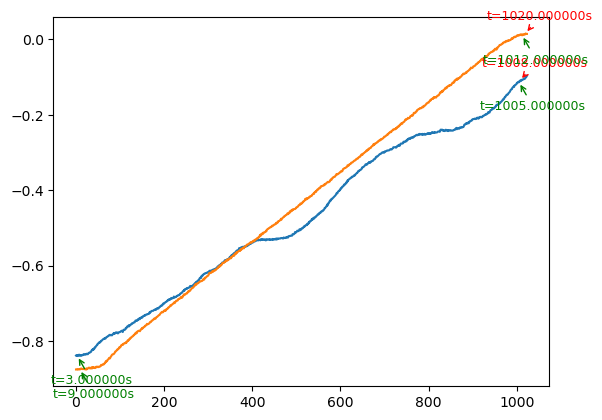

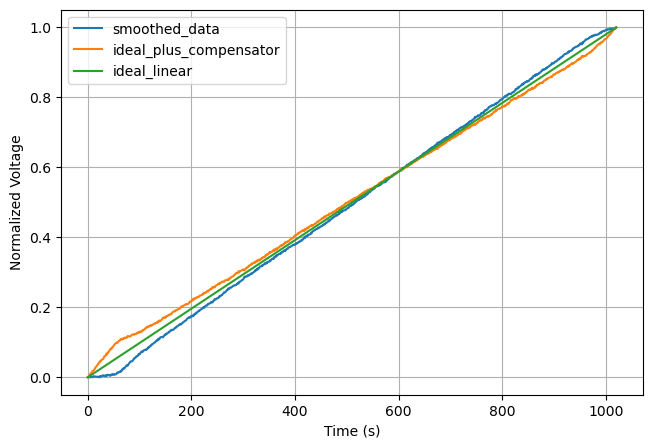

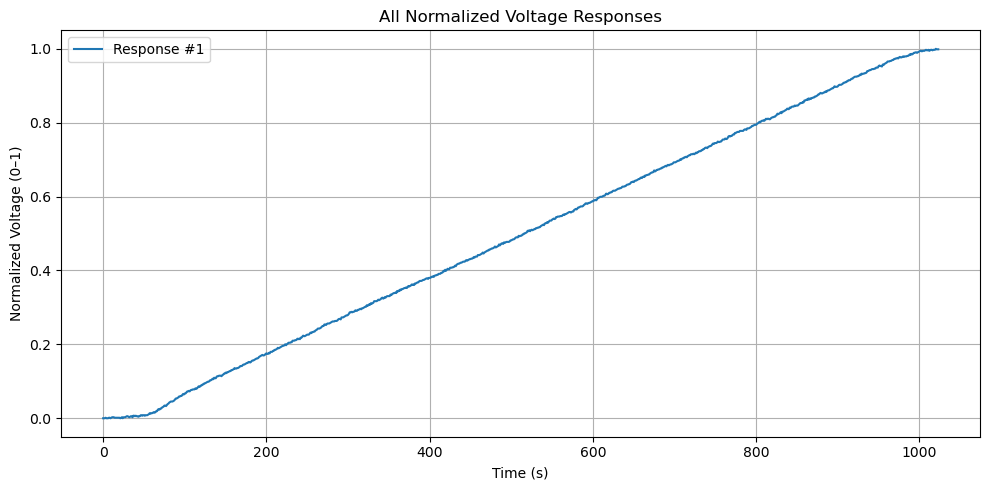

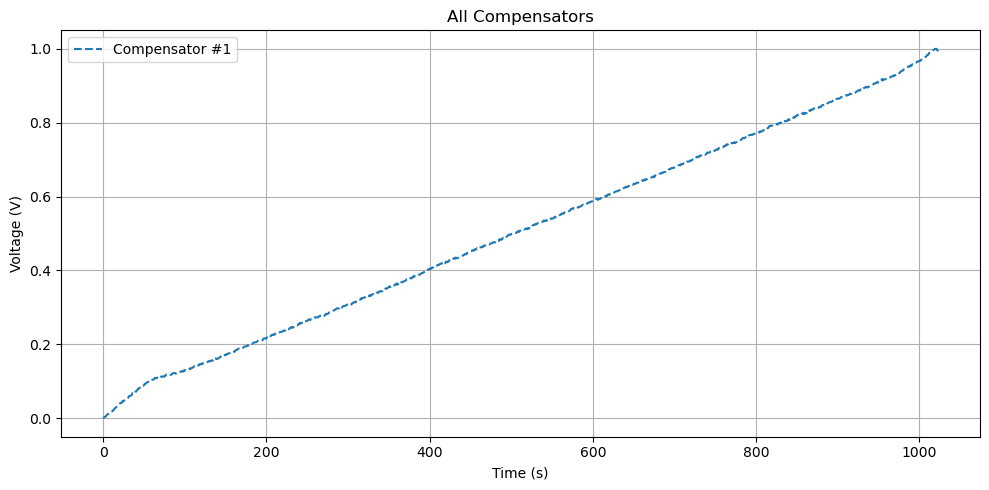


iteration===>>>2

[]
Length of combined_data_no_truncate: 1276


In [ ]:

def MukoAcadia_call(MukoAcadia,counter,VoiceCoilWaveForm):
    """
    Configure and upload a waveform to the Moku:Go Arbitrary Waveform Generator.

    Args:
        MukoAcadia: Moku:Go AWG instrument object.
        counter (int): Iteration counter (not directly used in this function, but kept for consistency).
        VoiceCoilWaveForm (array-like): Waveform data to be uploaded.

    Behavior:
        - Sends the waveform to channel 1 of the AWG.
        - Uses automatic sample rate, fixed frequency, amplitude, and offset.
    """
    MukoAcadia.generate_waveform(channel=1, sample_rate='Auto', lut_data=list(VoiceCoilWaveForm),  frequency=10, amplitude=4.8572, offset=0)

def MukoProbe_call(MukoProbe,counter):           
    """
    Acquire and process waveform data from the Moku:Go Oscilloscope.

    Args:
        MukoProbe: Moku:Go Oscilloscope instrument object.
        counter (int): Iteration counter, used to name output files.

    Workflow:
        1. Acquire oscilloscope data from Moku:Go.
        2. Save the raw dictionary data to a text file.
        3. Reload and parse the dictionary safely with `ast.literal_eval`.
        4. Apply a voltage flip (mirror over the mean value).
        5. Store the processed data in a DataFrame with columns 'second' and 'Volt'.
        6. Save the processed data as a tab-separated .txt file.
        7. Plot the flipped waveform (Voltage vs Time).
    """
    # Get new data
    data = MukoProbe.get_data()

    # Specify the filename
    filename = 'VC_respons'+str(counter)+'.txt'
    
    # # Writing the dictionary to a file as a string
    with open(filename, 'w') as file:
         file.write(str(data))
    
    # Step 1: Load and parse the file
    with open(filename, "r") as file:
        text = file.read()
        data = ast.literal_eval(text)  # Safely parse the dictionary
    
    # Step 2: Define voltage-flipping function (mirror over mean)
    def voltage_flip(ch1_data):
        ch1_array = np.array(ch1_data)
        flipped = -1 * (ch1_array - np.mean(ch1_array)) + np.mean(ch1_array)
        return flipped
    
    # Step 3: Apply voltage flip
    original_ch1 = np.array(data['ch1'])
    flipped_ch1 = voltage_flip(original_ch1)
    
    # Step 4: Create a DataFrame with renamed headers
    df = pd.DataFrame({
        "second": list(range(len(flipped_ch1))),
        "Volt": flipped_ch1
    })
    
    # Step 5: Save as tab-separated .txt file
    df.to_csv(filename, sep='\t', index=False)
    plt.plot(df['second'], df['Volt'], label='Voltage vs Time')


def main():
    """
    Main iterative control loop for waveform generation, measurement, and compensation.

    Workflow:
        - Initializes required variables and filenames.
        - Iterates until user chooses to stop.
        - On the first iteration:
            * Loads the initial linear waveform.
            * Sends it to the AWG (MokuAcadia_call).
            * Measures the response using the oscilloscope (MukoProbe_call).
        - On later iterations:
            * Loads the latest compensator waveform.
            * Sends it to the AWG and measures again.
        - After each iteration:
            * Runs the iterative compensation process.
            * Updates filenames for the next round.
            * Plots all responses and compensators collected so far.
        - Increments the iteration counter and repeats.
    """
    global counter, start_value, end_value, ideal_linear, start_time, end_time
    initial_filename = 'VC_respons1.txt'
    continue_with_iteration = True
    original_data = None
    previous_data = None
    previous_ideal_plus_compensator = None
    historical_compensator_scaled = []
    
    while continue_with_iteration:

        if counter==1:
            VCW = np.loadtxt('initial_linear_waveform.txt')
            MukoAcadia_call(MukoAcadia,counter,VCW)
            time.sleep(2)
            MukoProbe_call(MukoProbe,counter)
            time.sleep(10)
            
        else:
            VCW1 = np.loadtxt(Compensator_file)
            MukoAcadia_call(MukoAcadia,counter,VCW1)
            time.sleep(2)
            MukoProbe_call(MukoProbe,counter)
            

        print('\niteration===>>>'+str(counter)+'\n')

        continue_with_iteration, original_data, previous_data, previous_ideal_plus_compensator, historical_compensator_scaled = iterative_process(initial_filename, original_data, previous_data, previous_ideal_plus_compensator, historical_compensator_scaled)

        if continue_with_iteration:
            initial_filename = 'VC_respons'+str(counter+1)+'.txt'
            Compensator_file = 'Compensator_it_#_'+str(counter)+'.txt'

        plot_all_responses_and_compensators(folder='.', max_index=counter)



        counter = counter+1 
        
          
#Execute the main function
counter = 1 # Default initialization
start_value = None  
end_value = None
ideal_linear = None
start_time = None
end_time = None
time_data = None

main()